In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn.base import clone

import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Set a seed for reproducibility
seed_value = 42
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

## Data Loading

In [3]:
df_bank_a = pd.read_csv('../data/BankA_preprocessed.csv')
df_bank_b = pd.read_csv('../data/BankB_preprocessed.csv')
df_bank_c = pd.read_csv('../data/BankC_preprocessed.csv')

In [4]:
df_all = pd.concat([df_bank_a, df_bank_b, df_bank_c])

## Data Preprocessing

### Create bins for age

In [5]:
# Convert age in bins of 10 years
df_all['age'] = pd.cut(df_all['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_a['age'] = pd.cut(df_bank_a['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_b['age'] = pd.cut(df_bank_b['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])
df_bank_c['age'] = pd.cut(df_bank_c['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90'])

### Target Column

In [6]:
# One-hot encode the categorical columns
categorical_columns = df_all.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_all = pd.get_dummies(df_all, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_a.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_a = pd.get_dummies(df_bank_a, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_b.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_b = pd.get_dummies(df_bank_b, columns=categorical_columns)

# One-hot encode the categorical columns
categorical_columns = df_bank_c.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.append(pd.Index(['age']))
df_bank_c = pd.get_dummies(df_bank_c, columns=categorical_columns)

## Model Training

### Data Splitting for Training and Testing

In [7]:
# number of rows in each dataset
print(f"Number of rows in df_all:    {len(df_all)}")
print(f"Number of rows in df_bank_a: {len(df_bank_a)}")
print(f"Number of rows in df_bank_b: {len(df_bank_b)}")
print(f"Number of rows in df_bank_c: {len(df_bank_c)}")

Number of rows in df_all:    799999
Number of rows in df_bank_a: 226164
Number of rows in df_bank_b: 403240
Number of rows in df_bank_c: 170595


In [8]:
# Create a test set that contains 20% of the data from each bank
df_bank_a_test = df_bank_a.sample(frac=0.2, random_state=seed_value)
df_bank_b_test = df_bank_b.sample(frac=0.2, random_state=seed_value)
df_bank_c_test = df_bank_c.sample(frac=0.2, random_state=seed_value)

# Create a training set that contains the remaining 80% of the data from each bank
df_bank_a_train = df_bank_a.drop(df_bank_a_test.index)
df_bank_b_train = df_bank_b.drop(df_bank_b_test.index)
df_bank_c_train = df_bank_c.drop(df_bank_c_test.index)

# Combine the training sets into one training set
df_train = pd.concat([df_bank_a_train, df_bank_b_train, df_bank_c_train])

# Combine the test sets into one test set
df_test = pd.concat([df_bank_a_test, df_bank_b_test, df_bank_c_test])

In [9]:
# Split the training and test sets into X and y
X_train = df_train.drop('income', axis=1)
y_train = df_train['income']
X_test = df_test.drop('income', axis=1)
y_test = df_test['income']

X_train_bank_a = df_bank_a_train.drop('income', axis=1)
y_train_bank_a = df_bank_a_train['income']
X_test_bank_a = df_bank_a_test.drop('income', axis=1)
y_test_bank_a = df_bank_a_test['income']

X_train_bank_b = df_bank_b_train.drop('income', axis=1)
y_train_bank_b = df_bank_b_train['income']
X_test_bank_b = df_bank_b_test.drop('income', axis=1)
y_test_bank_b = df_bank_b_test['income']

X_train_bank_c = df_bank_c_train.drop('income', axis=1)
y_train_bank_c = df_bank_c_train['income']
X_test_bank_c = df_bank_c_test.drop('income', axis=1)
y_test_bank_c = df_bank_c_test['income']

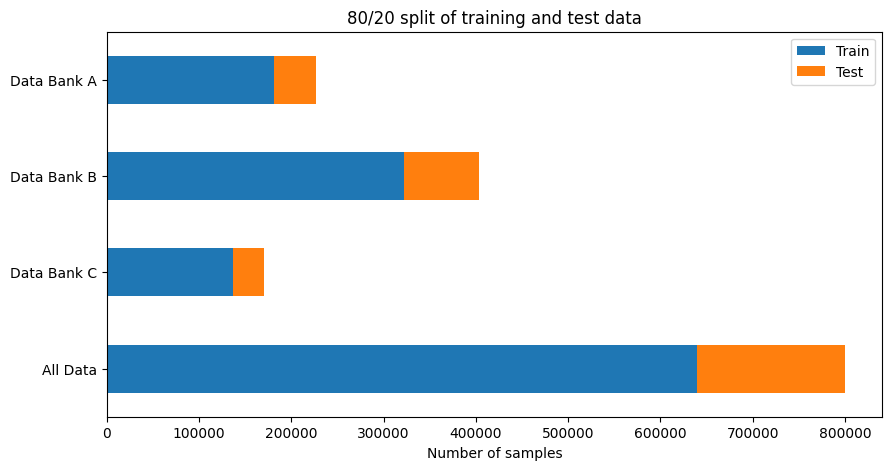

In [10]:
df_sample_count = pd.DataFrame({'Bank': ['Bank A', 'Bank B', 'Bank C', 'All'], 'Train': [len(df_bank_a_train), len(df_bank_b_train), len(df_bank_c_train), len(df_train)], 'Test': [len(df_bank_a_test), len(df_bank_b_test), len(df_bank_c_test), len(df_test)]})
df_sample_count = df_sample_count.set_index('Bank')
df_sample_count = df_sample_count.rename(index={'Bank A': 'Data Bank A', 'Bank B': 'Data Bank B', 'Bank C': 'Data Bank C', 'All': 'All Data'})

df_sample_count.plot.barh(stacked=True, figsize=(10, 5), title='80/20 split of training and test data')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.gca().invert_yaxis()
plt.ylabel('')
plt.xlabel('Number of samples')
plt.show()

### Model Training

In [14]:
N_ITER=1
CV=2

#### Finding good hyperparameters for different models

In [15]:
# Find the best hyperparameters for a decision tree classifier

# Create a decision tree classifier
clf_dt = DecisionTreeClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16],
    'max_features': [2, 4, 6, 8, 10, 12, 14, 16]
}

grid_search_dt = RandomizedSearchCV(estimator=clf_dt, n_iter=N_ITER, param_distributions=param_grid_dt, cv=CV, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_dt.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)
print(grid_search_dt.best_estimator_)

{'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 4, 'max_depth': 14, 'criterion': 'entropy'}
0.8143887594619437
DecisionTreeClassifier(criterion='entropy', max_depth=14, max_features=4,
                       min_samples_leaf=10, min_samples_split=14,
                       random_state=42)


In [16]:
# Find the best hyperparameters for a logistic regression classifier

# Create a logistic regression classifier
clf_lr = LogisticRegression(random_state=seed_value)

# Define the grid search parameters
param_grid_lg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000, 2000],
}

grid_search_lg = RandomizedSearchCV(estimator=clf_lr, n_iter=N_ITER, param_distributions=param_grid_lg, cv=CV, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_lg.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_lg.best_params_)
print(grid_search_lg.best_score_)
print(grid_search_lg.best_estimator_)

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'C': 0.001}
0.8107793615224188
LogisticRegression(C=0.001, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


In [17]:
# Find the best hyperparameters for a random forest classifier

# Create a random forest classifier
clf_rf = RandomForestClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_rf = {
    'n_estimators': [3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 10, 12, 14, 16, 32],
    'min_samples_split': [10, 32, 128, 256, 512, 1024],
    'min_samples_leaf': [16, 32, 64, 128, 256],
    'max_features': [2, 4, 6, 8, 10, 12, 14, 16]
}

grid_search_rf = RandomizedSearchCV(estimator=clf_rf, n_iter=N_ITER, param_distributions=param_grid_rf, cv=CV, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)
print(grid_search_rf.best_estimator_)

{'n_estimators': 3, 'min_samples_split': 1024, 'min_samples_leaf': 128, 'max_features': 4, 'max_depth': 12, 'criterion': 'entropy'}
0.8158496876552739
RandomForestClassifier(criterion='entropy', max_depth=12, max_features=4,
                       min_samples_leaf=128, min_samples_split=1024,
                       n_estimators=3, random_state=42)


In [18]:
# Find the best hyperparameters for a gradient boosting classifier

# Create a gradient boosting classifier
clf_gb = GradientBoostingClassifier(random_state=seed_value)

# Define the grid search parameters
param_grid_gb = {
    'n_estimators': [3, 9, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_depth': [2, 4, 6, 8, 10, 12, 36],
    'min_samples_split': [10, 12, 14, 16, 32, 128],
    'min_samples_leaf': [16, 32, 64, 128, 256],
    'max_features': [2, 4, 6, 8, 16, 20, 32]
}

grid_search_gb = RandomizedSearchCV(estimator=clf_gb, n_iter=N_ITER, param_distributions=param_grid_gb, cv=CV, n_jobs=-1, verbose=0)

# Train the grid search object to find the best model and the best hyperparameters
grid_search_gb.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search_gb.best_params_)
print(grid_search_gb.best_score_)
print(grid_search_gb.best_estimator_)

{'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 16, 'max_features': 8, 'max_depth': 10, 'learning_rate': 0.1}
0.8410262968351073
GradientBoostingClassifier(max_depth=10, max_features=8, min_samples_leaf=16,
                           min_samples_split=32, random_state=42)


In [11]:
# # Find the best hyperparameters for a MLP classifier

# # Create an MLP classifier
# clf_mlp = MLPClassifier(random_state=seed_value)

# # Define the grid search parameters
# param_grid_mlp = {
#     'hidden_layer_sizes': [(50, 30), (50,), (100,), (50, 50), (100, 50)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant', 'adaptive'],
#     'max_iter': [200, 300],
#     'learning_rate_init': [0.001, 0.01],
#     'batch_size': [64, 128]
# }

# grid_search_mlp = RandomizedSearchCV(estimator=clf_mlp, n_iter=N_ITER, param_distributions=param_grid_mlp, cv=CV, n_jobs=-1, verbose=0)

# # Train the grid search object to find the best model and the best hyperparameters
# grid_search_mlp.fit(X_train, y_train)

# # Print the best hyperparameters
# print(grid_search_mlp.best_params_)
# print(grid_search_mlp.best_score_)
# print(grid_search_mlp.best_estimator_)

{'solver': 'sgd', 'max_iter': 300, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'batch_size': 128, 'alpha': 0.0001, 'activation': 'tanh'}
0.802237206418605
MLPClassifier(activation='tanh', batch_size=128, hidden_layer_sizes=(50,),
              learning_rate_init=0.01, max_iter=300, random_state=42,
              solver='sgd')


In [11]:
# Define the best models with the best hyperparameters
dt_model = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=14,
    max_features=14,
    min_samples_leaf=14,
    min_samples_split=8,
    random_state=42,
)
lg_model = LogisticRegression(
    C=0.001, max_iter=2000, random_state=42, solver="liblinear"
)
rf_model = RandomForestClassifier(
    criterion="entropy",
    max_depth=12,
    max_features=16,
    min_samples_leaf=16,
    min_samples_split=128,
    n_estimators=5,
    random_state=42,
)
gb_model = GradientBoostingClassifier(
    max_depth=10, max_features=8, min_samples_leaf=16, min_samples_split=32
)

In [12]:
# Define and Train the models with the best hyperparameters
model_global_dt = clone(dt_model).fit(X_train, y_train)
model_global_lg = clone(lg_model).fit(X_train, y_train)
model_global_rf = clone(rf_model).fit(X_train, y_train)
model_global_gb = clone(gb_model).fit(X_train, y_train)
# model_global_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train, y_train)

model_bank_a_dt = clone(dt_model).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_lg = clone(lg_model).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_rf = clone(rf_model).fit(X_train_bank_a, y_train_bank_a)
model_bank_a_gb = clone(gb_model).fit(X_train_bank_a, y_train_bank_a)
# model_bank_a_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_a, y_train_bank_a)

model_bank_b_dt = clone(dt_model).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_lg = clone(lg_model).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_rf = clone(rf_model).fit(X_train_bank_b, y_train_bank_b)
model_bank_b_gb = clone(gb_model).fit(X_train_bank_b, y_train_bank_b)
# model_bank_b_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_b, y_train_bank_b)

model_bank_c_dt = clone(dt_model).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_lg = clone(lg_model).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_rf = clone(rf_model).fit(X_train_bank_c, y_train_bank_c)
model_bank_c_gb = clone(gb_model).fit(X_train_bank_c, y_train_bank_c)
# model_bank_c_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_c, y_train_bank_c)

#### Train a model with all data from all banks

In [ ]:
# # Define and Train the models with the best hyperparameters
# model_global_dt = clone(grid_search_dt.best_estimator_).fit(X_train, y_train)
# model_global_lg = clone(grid_search_lg.best_estimator_).fit(X_train, y_train)
# model_global_rf = clone(grid_search_rf.best_estimator_).fit(X_train, y_train)
# model_global_gb = clone(grid_search_gb.best_estimator_).fit(X_train, y_train)
# # model_global_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train, y_train)

# model_bank_a_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
# model_bank_a_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
# model_bank_a_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
# model_bank_a_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_a, y_train_bank_a)
# # model_bank_a_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_a, y_train_bank_a)

# model_bank_b_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
# model_bank_b_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
# model_bank_b_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
# model_bank_b_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_b, y_train_bank_b)
# # model_bank_b_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_b, y_train_bank_b)

# model_bank_c_dt = clone(grid_search_dt.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
# model_bank_c_lg = clone(grid_search_lg.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
# model_bank_c_rf = clone(grid_search_rf.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
# model_bank_c_gb = clone(grid_search_gb.best_estimator_).fit(X_train_bank_c, y_train_bank_c)
# # model_bank_c_mlp = clone(grid_search_mlp.best_estimator_).fit(X_train_bank_c, y_train_bank_c)

In [23]:
# Export the trained models
# joblib.dump(model_global_dt, './models/model_global_dt.pkl')
# joblib.dump(model_global_lg, './models/model_global_lg.pkl')
# joblib.dump(model_global_rf, './models/model_global_rf.pkl')
# joblib.dump(model_global_gb, './models/model_global_gb.pkl')
# joblib.dump(model_global_mlp, './models/model_global_mlp.pkl')

# joblib.dump(model_bank_a_dt, './models/model_bank_a_dt.pkl')
# joblib.dump(model_bank_a_lg, './models/model_bank_a_lg.pkl')
# joblib.dump(model_bank_a_rf, './models/model_bank_a_rf.pkl')
# joblib.dump(model_bank_a_gb, './models/model_bank_a_gb.pkl')
# joblib.dump(model_bank_a_mlp, './models/model_bank_a_mlp.pkl')

# joblib.dump(model_bank_b_dt, './models/model_bank_b_dt.pkl')
# joblib.dump(model_bank_b_lg, './models/model_bank_b_lg.pkl')
# joblib.dump(model_bank_b_rf, './models/model_bank_b_rf.pkl')
# joblib.dump(model_bank_b_gb, './models/model_bank_b_gb.pkl')
# joblib.dump(model_bank_b_mlp, './models/model_bank_b_mlp.pkl')

# joblib.dump(model_bank_c_dt, './models/model_bank_c_dt.pkl')
# joblib.dump(model_bank_c_lg, './models/model_bank_c_lg.pkl')
# joblib.dump(model_bank_c_rf, './models/model_bank_c_rf.pkl')
# joblib.dump(model_bank_c_gb, './models/model_bank_c_gb.pkl')
# joblib.dump(model_bank_c_mlp, './models/model_bank_c_mlp.pkl')

# Load the trained models
# model_global_dt = joblib.load('./models/model_global_dt.pkl')
# model_global_lg = joblib.load('./models/model_global_lg.pkl')
# model_global_rf = joblib.load('./models/model_global_rf.pkl')
# model_global_gb = joblib.load('./models/model_global_gb.pkl')
# model_global_mlp = joblib.load('./models/model_global_mlp.pkl')

# model_bank_a_dt = joblib.load('./models/model_bank_a_dt.pkl')
# model_bank_a_lg = joblib.load('./models/model_bank_a_lg.pkl')
# model_bank_a_rf = joblib.load('./models/model_bank_a_rf.pkl')
# model_bank_a_gb = joblib.load('./models/model_bank_a_gb.pkl')
# model_bank_a_mlp = joblib.load('./models/model_bank_a_mlp.pkl')

# model_bank_b_dt = joblib.load('./models/model_bank_b_dt.pkl')
# model_bank_b_lg = joblib.load('./models/model_bank_b_lg.pkl')
# model_bank_b_rf = joblib.load('./models/model_bank_b_rf.pkl')
# model_bank_b_gb = joblib.load('./models/model_bank_b_gb.pkl')
# model_bank_b_mlp = joblib.load('./models/model_bank_b_mlp.pkl')

# model_bank_c_dt = joblib.load('./models/model_bank_c_dt.pkl')
# model_bank_c_lg = joblib.load('./models/model_bank_c_lg.pkl')
# model_bank_c_rf = joblib.load('./models/model_bank_c_rf.pkl')
# model_bank_c_gb = joblib.load('./models/model_bank_c_gb.pkl')
# model_bank_c_mlp = joblib.load('./models/model_bank_c_mlp.pkl')

#### Evaluate all the models

In [13]:
# Evaluate the global models on the global test set

## Predict
y_pred_global_global_dt = model_global_dt.predict(X_test)
y_pred_global_global_lg = model_global_lg.predict(X_test)
y_pred_global_global_rf = model_global_rf.predict(X_test)
y_pred_global_global_gb = model_global_gb.predict(X_test)
# y_pred_global_global_mlp = model_global_mlp.predict(X_test)
## Metrics
acc_global_global_dt = accuracy_score(y_test, y_pred_global_global_dt)
acc_global_global_lg = accuracy_score(y_test, y_pred_global_global_lg)
acc_global_global_rf = accuracy_score(y_test, y_pred_global_global_rf)
acc_global_global_gb = accuracy_score(y_test, y_pred_global_global_gb)
# acc_global_global_mlp = accuracy_score(y_test, y_pred_global_global_mlp)
f1_global_global_dt = f1_score(y_test, y_pred_global_global_dt)
f1_global_global_lg = f1_score(y_test, y_pred_global_global_lg)
f1_global_global_rf = f1_score(y_test, y_pred_global_global_rf)
f1_global_global_gb = f1_score(y_test, y_pred_global_global_gb)
# f1_global_global_mlp = f1_score(y_test, y_pred_global_global_mlp)
kappa_global_global_dt = cohen_kappa_score(y_test, y_pred_global_global_dt)
kappa_global_global_lg = cohen_kappa_score(y_test, y_pred_global_global_lg)
kappa_global_global_rf = cohen_kappa_score(y_test, y_pred_global_global_rf)
kappa_global_global_gb = cohen_kappa_score(y_test, y_pred_global_global_gb)
# kappa_global_global_mlp = cohen_kappa_score(y_test, y_pred_global_global_mlp)

# Evaluate the global models on the bank A, B and C test sets
## Predict
y_pred_global_bank_a_dt = model_global_dt.predict(X_test_bank_a)
y_pred_global_bank_a_lg = model_global_lg.predict(X_test_bank_a)
y_pred_global_bank_a_rf = model_global_rf.predict(X_test_bank_a)
y_pred_global_bank_a_gb = model_global_gb.predict(X_test_bank_a)
# y_pred_global_bank_a_mlp = model_global_mlp.predict(X_test_bank_a)

y_pred_global_bank_b_dt = model_global_dt.predict(X_test_bank_b)
y_pred_global_bank_b_lg = model_global_lg.predict(X_test_bank_b)
y_pred_global_bank_b_rf = model_global_rf.predict(X_test_bank_b)
y_pred_global_bank_b_gb = model_global_gb.predict(X_test_bank_b)
# y_pred_global_bank_b_mlp = model_global_mlp.predict(X_test_bank_b)

y_pred_global_bank_c_dt = model_global_dt.predict(X_test_bank_c)
y_pred_global_bank_c_lg = model_global_lg.predict(X_test_bank_c)
y_pred_global_bank_c_rf = model_global_rf.predict(X_test_bank_c)
y_pred_global_bank_c_gb = model_global_gb.predict(X_test_bank_c)
# y_pred_global_bank_c_mlp = model_global_mlp.predict(X_test_bank_c)
## Metrics
acc_global_bank_a_dt = accuracy_score(y_test_bank_a, y_pred_global_bank_a_dt)
acc_global_bank_a_lg = accuracy_score(y_test_bank_a, y_pred_global_bank_a_lg)
acc_global_bank_a_rf = accuracy_score(y_test_bank_a, y_pred_global_bank_a_rf)
acc_global_bank_a_gb = accuracy_score(y_test_bank_a, y_pred_global_bank_a_gb)
# acc_global_bank_a_mlp = accuracy_score(y_test_bank_a, y_pred_global_bank_a_mlp)
f1_global_bank_a_dt = f1_score(y_test_bank_a, y_pred_global_bank_a_dt)
f1_global_bank_a_lg = f1_score(y_test_bank_a, y_pred_global_bank_a_lg)
f1_global_bank_a_rf = f1_score(y_test_bank_a, y_pred_global_bank_a_rf)
f1_global_bank_a_gb = f1_score(y_test_bank_a, y_pred_global_bank_a_gb)
# f1_global_bank_a_mlp = f1_score(y_test_bank_a, y_pred_global_bank_a_mlp)
kappa_global_bank_a_dt = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_dt)
kappa_global_bank_a_lg = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_lg)
kappa_global_bank_a_rf = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_rf)
kappa_global_bank_a_gb = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_gb)
# kappa_global_bank_a_mlp = cohen_kappa_score(y_test_bank_a, y_pred_global_bank_a_mlp)

acc_global_bank_b_dt = accuracy_score(y_test_bank_b, y_pred_global_bank_b_dt)
acc_global_bank_b_lg = accuracy_score(y_test_bank_b, y_pred_global_bank_b_lg)
acc_global_bank_b_rf = accuracy_score(y_test_bank_b, y_pred_global_bank_b_rf)
acc_global_bank_b_gb = accuracy_score(y_test_bank_b, y_pred_global_bank_b_gb)
# acc_global_bank_b_mlp = accuracy_score(y_test_bank_b, y_pred_global_bank_b_mlp)
f1_global_bank_b_dt = f1_score(y_test_bank_b, y_pred_global_bank_b_dt)
f1_global_bank_b_lg = f1_score(y_test_bank_b, y_pred_global_bank_b_lg)
f1_global_bank_b_rf = f1_score(y_test_bank_b, y_pred_global_bank_b_rf)
f1_global_bank_b_gb = f1_score(y_test_bank_b, y_pred_global_bank_b_gb)
# f1_global_bank_b_mlp = f1_score(y_test_bank_b, y_pred_global_bank_b_mlp)
kappa_global_bank_b_dt = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_dt)
kappa_global_bank_b_lg = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_lg)
kappa_global_bank_b_rf = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_rf)
kappa_global_bank_b_gb = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_gb)
# kappa_global_bank_b_mlp = cohen_kappa_score(y_test_bank_b, y_pred_global_bank_b_mlp)

acc_global_bank_c_dt = accuracy_score(y_test_bank_c, y_pred_global_bank_c_dt)
acc_global_bank_c_lg = accuracy_score(y_test_bank_c, y_pred_global_bank_c_lg)
acc_global_bank_c_rf = accuracy_score(y_test_bank_c, y_pred_global_bank_c_rf)
acc_global_bank_c_gb = accuracy_score(y_test_bank_c, y_pred_global_bank_c_gb)
# acc_global_bank_c_mlp = accuracy_score(y_test_bank_c, y_pred_global_bank_c_mlp)
f1_global_bank_c_dt = f1_score(y_test_bank_c, y_pred_global_bank_c_dt)
f1_global_bank_c_lg = f1_score(y_test_bank_c, y_pred_global_bank_c_lg)
f1_global_bank_c_rf = f1_score(y_test_bank_c, y_pred_global_bank_c_rf)
f1_global_bank_c_gb = f1_score(y_test_bank_c, y_pred_global_bank_c_gb)
# f1_global_bank_c_mlp = f1_score(y_test_bank_c, y_pred_global_bank_c_mlp)
kappa_global_bank_c_dt = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_dt)
kappa_global_bank_c_lg = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_lg)
kappa_global_bank_c_rf = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_rf)
kappa_global_bank_c_gb = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_gb)
# kappa_global_bank_c_mlp = cohen_kappa_score(y_test_bank_c, y_pred_global_bank_c_mlp)


# Evaluate the bank A models on the bank A test set
## Predict
y_pred_bank_a_bank_a_dt = model_bank_a_dt.predict(X_test_bank_a)
y_pred_bank_a_bank_a_lg = model_bank_a_lg.predict(X_test_bank_a)
y_pred_bank_a_bank_a_rf = model_bank_a_rf.predict(X_test_bank_a)
y_pred_bank_a_bank_a_gb = model_bank_a_gb.predict(X_test_bank_a)
# y_pred_bank_a_bank_a_mlp = model_bank_a_mlp.predict(X_test_bank_a)
## Metrics
acc_bank_a_bank_a_dt = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
acc_bank_a_bank_a_lg = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
acc_bank_a_bank_a_rf = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
acc_bank_a_bank_a_gb = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)
# acc_bank_a_bank_a_mlp = accuracy_score(y_test_bank_a, y_pred_bank_a_bank_a_mlp)
f1_bank_a_bank_a_dt = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
f1_bank_a_bank_a_lg = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
f1_bank_a_bank_a_rf = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
f1_bank_a_bank_a_gb = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)
# f1_bank_a_bank_a_mlp = f1_score(y_test_bank_a, y_pred_bank_a_bank_a_mlp)
kappa_bank_a_bank_a_dt = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_dt)
kappa_bank_a_bank_a_lg = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_lg)
kappa_bank_a_bank_a_rf = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_rf)
kappa_bank_a_bank_a_gb = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_gb)
# kappa_bank_a_bank_a_mlp = cohen_kappa_score(y_test_bank_a, y_pred_bank_a_bank_a_mlp)


# Evaluate the bank B models on the bank B test set
## Predict
y_pred_bank_b_bank_b_dt = model_bank_b_dt.predict(X_test_bank_b)
y_pred_bank_b_bank_b_lg = model_bank_b_lg.predict(X_test_bank_b)
y_pred_bank_b_bank_b_rf = model_bank_b_rf.predict(X_test_bank_b)
y_pred_bank_b_bank_b_gb = model_bank_b_gb.predict(X_test_bank_b)
# y_pred_bank_b_bank_b_mlp = model_bank_b_mlp.predict(X_test_bank_b)
## Metrics
acc_bank_b_bank_b_dt = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
acc_bank_b_bank_b_lg = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
acc_bank_b_bank_b_rf = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
acc_bank_b_bank_b_gb = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)
# acc_bank_b_bank_b_mlp = accuracy_score(y_test_bank_b, y_pred_bank_b_bank_b_mlp)
f1_bank_b_bank_b_dt = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
f1_bank_b_bank_b_lg = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
f1_bank_b_bank_b_rf = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
f1_bank_b_bank_b_gb = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)
# f1_bank_b_bank_b_mlp = f1_score(y_test_bank_b, y_pred_bank_b_bank_b_mlp)
kappa_bank_b_bank_b_dt = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_dt)
kappa_bank_b_bank_b_lg = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_lg)
kappa_bank_b_bank_b_rf = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_rf)
kappa_bank_b_bank_b_gb = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_gb)
# kappa_bank_b_bank_b_mlp = cohen_kappa_score(y_test_bank_b, y_pred_bank_b_bank_b_mlp)


# Evaluate the bank C models on the bank C test set
## Predict
y_pred_bank_c_bank_c_dt = model_bank_c_dt.predict(X_test_bank_c)
y_pred_bank_c_bank_c_lg = model_bank_c_lg.predict(X_test_bank_c)
y_pred_bank_c_bank_c_rf = model_bank_c_rf.predict(X_test_bank_c)
y_pred_bank_c_bank_c_gb = model_bank_c_gb.predict(X_test_bank_c)
# y_pred_bank_c_bank_c_mlp = model_bank_c_mlp.predict(X_test_bank_c)
## Metrics
acc_bank_c_bank_c_dt = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
acc_bank_c_bank_c_lg = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
acc_bank_c_bank_c_rf = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
acc_bank_c_bank_c_gb = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)
# acc_bank_c_bank_c_mlp = accuracy_score(y_test_bank_c, y_pred_bank_c_bank_c_mlp)
f1_bank_c_bank_c_dt = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
f1_bank_c_bank_c_lg = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
f1_bank_c_bank_c_rf = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
f1_bank_c_bank_c_gb = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)
# f1_bank_c_bank_c_mlp = f1_score(y_test_bank_c, y_pred_bank_c_bank_c_mlp)
kappa_bank_c_bank_c_dt = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_dt)
kappa_bank_c_bank_c_lg = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_lg)
kappa_bank_c_bank_c_rf = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_rf)
kappa_bank_c_bank_c_gb = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_gb)
# kappa_bank_c_bank_c_mlp = cohen_kappa_score(y_test_bank_c, y_pred_bank_c_bank_c_mlp)

In [14]:
# Store all metrics in a dataframe with columns: modeltype, explainability, model, dataset , accuracy, f1, kappa
df_metrics = pd.DataFrame(columns=['modeltype', 'explainability', 'model', 'dataset', 'accuracy', 'f1', 'kappa'])

# Add the global models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'Global Model', 'dataset': 'global dataset', 'accuracy': acc_global_global_dt, 'f1': f1_global_global_dt, 'kappa': kappa_global_global_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'Global Model', 'dataset': 'global dataset', 'accuracy': acc_global_global_lg, 'f1': f1_global_global_lg, 'kappa': kappa_global_global_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'global dataset', 'accuracy': acc_global_global_rf, 'f1': f1_global_global_rf, 'kappa': kappa_global_global_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'global dataset', 'accuracy': acc_global_global_gb, 'f1': f1_global_global_gb, 'kappa': kappa_global_global_gb}, index=[0])], ignore_index=True)
# df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'multilayer perceptron', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'global dataset', 'accuracy': acc_global_global_mlp, 'f1': f1_global_global_mlp, 'kappa': kappa_global_global_mlp}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'Global Model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_dt, 'f1': f1_global_bank_a_dt, 'kappa': kappa_global_bank_a_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'Global Model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_lg, 'f1': f1_global_bank_a_lg, 'kappa': kappa_global_bank_a_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_rf, 'f1': f1_global_bank_a_rf, 'kappa': kappa_global_bank_a_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_gb, 'f1': f1_global_bank_a_gb, 'kappa': kappa_global_bank_a_gb}, index=[0])], ignore_index=True)
# df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'multilayer perceptron', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank A dataset', 'accuracy': acc_global_bank_a_mlp, 'f1': f1_global_bank_a_mlp, 'kappa': kappa_global_bank_a_mlp}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'Global Model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_dt, 'f1': f1_global_bank_b_dt, 'kappa': kappa_global_bank_b_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'Global Model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_lg, 'f1': f1_global_bank_b_lg, 'kappa': kappa_global_bank_b_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_rf, 'f1': f1_global_bank_b_rf, 'kappa': kappa_global_bank_b_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_gb, 'f1': f1_global_bank_b_gb, 'kappa': kappa_global_bank_b_gb}, index=[0])], ignore_index=True)
# df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'multilayer perceptron', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank B dataset', 'accuracy': acc_global_bank_b_mlp, 'f1': f1_global_bank_b_mlp, 'kappa': kappa_global_bank_b_mlp}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'Global Model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_dt, 'f1': f1_global_bank_c_dt, 'kappa': kappa_global_bank_c_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'Global Model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_lg, 'f1': f1_global_bank_c_lg, 'kappa': kappa_global_bank_c_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_rf, 'f1': f1_global_bank_c_rf, 'kappa': kappa_global_bank_c_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_gb, 'f1': f1_global_bank_c_gb, 'kappa': kappa_global_bank_c_gb}, index=[0])], ignore_index=True)
# df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'multilayer perceptron', 'explainability': 'low', 'model': 'Global Model', 'dataset': 'bank C dataset', 'accuracy': acc_global_bank_c_mlp, 'f1': f1_global_bank_c_mlp, 'kappa': kappa_global_bank_c_mlp}, index=[0])], ignore_index=True)

# Add the bank A models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'Bank A Model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_dt, 'f1': f1_bank_a_bank_a_dt, 'kappa': kappa_bank_a_bank_a_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'Bank A Model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_lg, 'f1': f1_bank_a_bank_a_lg, 'kappa': kappa_bank_a_bank_a_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'Bank A Model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_rf, 'f1': f1_bank_a_bank_a_rf, 'kappa': kappa_bank_a_bank_a_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'Bank A Model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_gb, 'f1': f1_bank_a_bank_a_gb, 'kappa': kappa_bank_a_bank_a_gb}, index=[0])], ignore_index=True)
# df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'multilayer perceptron', 'explainability': 'low', 'model': 'Bank A Model', 'dataset': 'bank A dataset', 'accuracy': acc_bank_a_bank_a_mlp, 'f1': f1_bank_a_bank_a_mlp, 'kappa': kappa_bank_a_bank_a_mlp}, index=[0])], ignore_index=True)

# Add the bank B models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'Bank B Model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_dt, 'f1': f1_bank_b_bank_b_dt, 'kappa': kappa_bank_b_bank_b_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'Bank B Model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_lg, 'f1': f1_bank_b_bank_b_lg, 'kappa': kappa_bank_b_bank_b_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'Bank B Model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_rf, 'f1': f1_bank_b_bank_b_rf, 'kappa': kappa_bank_b_bank_b_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'Bank B Model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_gb, 'f1': f1_bank_b_bank_b_gb, 'kappa': kappa_bank_b_bank_b_gb}, index=[0])], ignore_index=True)
# df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'multilayer perceptron', 'explainability': 'low', 'model': 'Bank B Model', 'dataset': 'bank B dataset', 'accuracy': acc_bank_b_bank_b_mlp, 'f1': f1_bank_b_bank_b_mlp, 'kappa': kappa_bank_b_bank_b_mlp}, index=[0])], ignore_index=True)

# Add the bank C models to the dataframe
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'decision tree', 'explainability': 'high', 'model': 'Bank C Model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_dt, 'f1': f1_bank_c_bank_c_dt, 'kappa': kappa_bank_c_bank_c_dt}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'logistic regression', 'explainability': 'high', 'model': 'Bank C Model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_lg, 'f1': f1_bank_c_bank_c_lg, 'kappa': kappa_bank_c_bank_c_lg}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'random forest', 'explainability': 'low', 'model': 'Bank C Model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_rf, 'f1': f1_bank_c_bank_c_rf, 'kappa': kappa_bank_c_bank_c_rf}, index=[0])], ignore_index=True)
df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'gradient boosting', 'explainability': 'low', 'model': 'Bank C Model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_gb, 'f1': f1_bank_c_bank_c_gb, 'kappa': kappa_bank_c_bank_c_gb}, index=[0])], ignore_index=True)
# df_metrics = pd.concat([df_metrics, pd.DataFrame({'modeltype': 'multilayer perceptron', 'explainability': 'low', 'model': 'Bank C Model', 'dataset': 'bank C dataset', 'accuracy': acc_bank_c_bank_c_mlp, 'f1': f1_bank_c_bank_c_mlp, 'kappa': kappa_bank_c_bank_c_mlp}, index=[0])], ignore_index=True)

In [15]:
# Rename dataset to testdataset
df_metrics = df_metrics.rename(columns={'dataset': 'Test-Dataset'})
df_metrics = df_metrics.rename(columns={'modeltype': 'Model-Type'})
df_metrics = df_metrics.rename(columns={'model': 'Model'})
df_metrics = df_metrics.rename(columns={'accuracy': 'Accuracy'})

df_metrics['Model-Type'].replace({'logistic regression': 'LogisticRegression'}, inplace=True)
df_metrics['Model-Type'].replace({'decision tree': 'DecisionTree'}, inplace=True)
df_metrics['Model-Type'].replace({'random forest': 'RandomForest'}, inplace=True)
df_metrics['Model-Type'].replace({'gradient boosting': 'GradientBoosting'}, inplace=True)
df_metrics['Test-Dataset'].replace({'bank A dataset': 'Bank A Dataset'}, inplace=True)
df_metrics['Test-Dataset'].replace({'bank B dataset': 'Bank B Dataset'}, inplace=True)
df_metrics['Test-Dataset'].replace({'bank C dataset': 'Bank C Dataset'}, inplace=True)

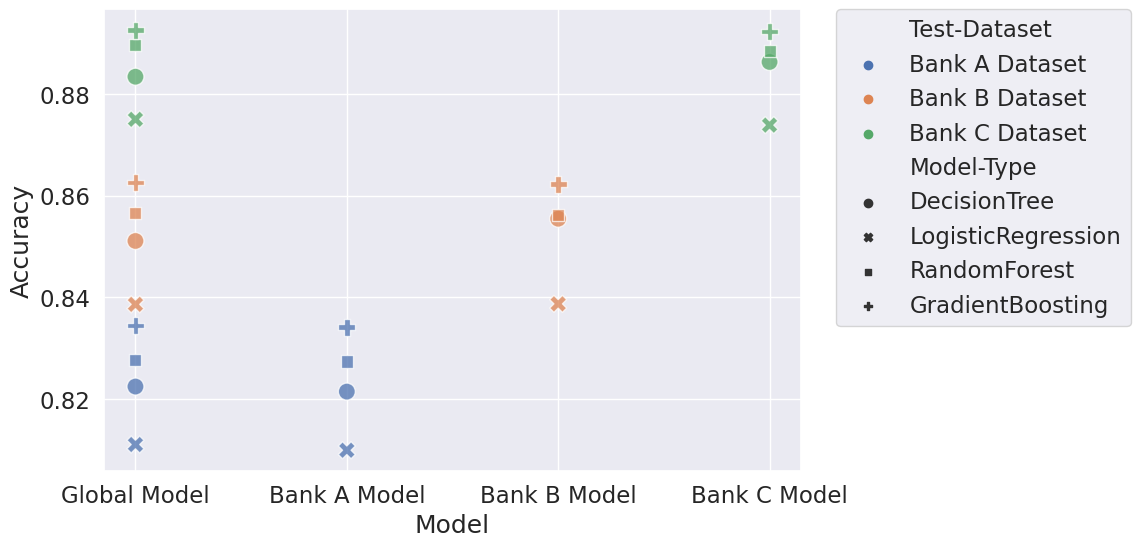

In [16]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})
sns.set(font_scale=1.5)
ax = sns.scatterplot(x="Model", y="Accuracy", hue="Test-Dataset", style="Model-Type", data=df_metrics[df_metrics['Test-Dataset'] != 'global dataset'], s=150, alpha=0.75)
ax.set(xlabel='Model', ylabel='Accuracy')
# Rename the legend titles
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()